<a href="https://colab.research.google.com/github/olahfemi/FashionMNISTSolution/blob/master/Group_Project_BenchMark_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Project

This notebook along with the [TensorFlow and deep learning, without a PhD](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#0) codelabs should serve as a starter guide for your group projects. For the project, you are to build a model that achieves a minimum of 96% accuracy for a classification task on the MNIST dataset. This can be achieved by several methods, but you are required to follow some certain steps as outlined below:

1. Load the mnist dataset from tensorflow. This consists of the train, validation, and test sets.
    The train set has 55000 examples,
    The validation set has 5000 examples, and
    the test set has 10000 examples.
    
2. Visualize the examples in each set.
 
3. Build a softmax regression model (a 1 layer neural network)and train it on the dataset.

4. Add a hidden layer of 200 neurons, use sigmoid activation for hidden units, train and obtain train, validation and test accuracies and loss

5. Build a five layers neural network with sigmoid activation

6. Replace the sigmoid activations with relu

7. Introduce learning rate decay

8. Use dropout

9. Convolutional Neural Networks


In [1]:
#@title All imports and Initializations(RUN THIS CELL!)
'''
Obtain MNIST dataset using tensorflow
'''
import tensorflow as tf
import math
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

mnist = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/', one_hot=True)

fashion_class = {0:'shirt/top',
                1: 	'Trouser',
                2: 	'Pullover',
                3: 	'Dress',
                4: 	'Coat',
                5: 	'Sandal',
                6: 	'Shirt',
                7: 	'Sneaker',
                8: 	'Bag',
                9: 	'Ankle boot'
                }

def view_image(x,y):
  '''
  View 10 random images from a dataset
  
  input:
    x => ndarray[of shape (m x n)] (examples)
    y => ndarray[of shape (m x c)] (onehot encoded)
          m = no of examples
          c = no of classes
  output:
    None.
   
  '''
  f, axarr = plt.subplots(2,5)
  
  for ax in f.axes:
    i = np.random.randint(x.shape[0]) # pick a random example (ith example)
    ax.get_xaxis().set_ticks([]) # don't label the xaxis
    ax.get_yaxis().set_ticks([]) # don't label the yais
    ax.text(0,0, fashion_class[np.argmax(y[i])]) # display a text containing the ith example's class
    ax.imshow(x[i].reshape(28,28)) # display the ith example

    
    
# This function does the training

def training(X_train, y_train, X_val, y_val, sess, epochs = 1, mini_batch = 100, step=None, pkeep=None):
  
    '''
    **arguments**
    X_train:
      The input feature matrix
    y_train:
      The output true label
    X_val:
      The validation set feature matrix
    y_val:
      The validation set true label
    sess:
      A tensorflow session to run the computational graph
    epochs:
      No of times to run through the entire examples 
    mini_batch:
      No of examples to use in each train step
      
      
    **returns**
    history: tuple
      a tuple containing the train and validation accuracies and losses
      
    '''
    
    accuracies = []
    loss = []
    accuracies_validation = []
    loss_validation = []
    
    steps_per_epoch = int(X_train.shape[0]/mini_batch)
    training_steps = epochs * steps_per_epoch
  
    for i in range(1,training_steps+1):
      # pick a mini batch from the training
      s = i%steps_per_epoch
      batch_X, batch_Y = X_train[(s-1)*mini_batch:(s)*mini_batch], y_train[(s-1)*mini_batch:(s)*mini_batch]

      # compute train/validation loss and accuracy
      if i%steps_per_epoch == 0:
          # train
          if(step != None and pkeep == None):
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: X_train, y: y_train})
          if(step == None and pkeep != None):
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: X_train, y: y_train, pkeep_val: pkeep})
          if(step != None and pkeep != None):
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: X_train, y: y_train, pkeep_val: pkeep})
          if(step == None and pkeep == None):
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: X_train, y: y_train})
          loss.append(c)
          accuracies.append(a)
          print("EPOCH " + str(i/steps_per_epoch) + "\n" + " train accuracy:" + str(a) + "train loss: " + str(c))
          
          # validation
          if(step != None and pkeep == None):
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: X_val, y: y_val})
          if(step == None and pkeep != None):
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: X_val, y: y_val, pkeep_val: 1})
          if(step != None and pkeep != None):
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: X_val, y: y_val, pkeep_val: 1})
          if(step == None and pkeep == None):
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: X_val, y: y_val})
         
          loss_validation.append(c)
          accuracies_validation.append(a)
          print(" ********* validation accuracy:" + str(a) + " validation loss: " + str(c))

      # the backpropagation training step
     
      if(step != None and pkeep == None):
        sess.run(train_step, feed_dict={X: batch_X, y: batch_Y, step_val: i})
      if(step == None and pkeep != None):
        sess.run(train_step, feed_dict={X: batch_X, y: batch_Y, pkeep_val: pkeep})
      if(step != None and pkeep != None):
        sess.run([train_step], feed_dict={X: X_val, y: y_val, step_val: i, pkeep_val: pkeep})
      if(step == None and pkeep == None):
        sess.run(train_step, feed_dict={X: X_val, y: y_val})
         
      
      history = (accuracies, loss, accuracies_validation, loss_validation)
      
    return history
  


def plot_history(history):
  accuracies, loss, accuracies_validation, loss_validation = history
  f, ax = plt.subplots(2,2)
  ax[0,0].plot(accuracies)
  ax[0,0].set(xlabel='epochs', ylabel='train_accuracy')

  ax[0,1].plot(loss )
  ax[0,1].set(xlabel='epochs', ylabel='train_loss')

  ax[1,0].plot(accuracies_validation)
  ax[1,0].set(xlabel='epochs', ylabel='val_accuracy')


  ax[1,1].plot(loss_validation)
  ax[1,1].set(xlabel='epochs', ylabel='val_loss')
  

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 26421880 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 29515 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 4422102 bytes.
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 5148 bytes.
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/data

## 1. Load the dataset
for the train set, x_train contains the 55000 train images and y_train contains the onehot encoded label. Same applies to the validation and test set


In [0]:
x_train = mnist.train.images
y_train = mnist.train.labels
x_val = mnist.validation.images
y_val = mnist.validation.labels
x_test = mnist.test.images
y_test = mnist.test.labels

The train images are 28x28 gray scale images. But the loaded images are flattened to be of size (1x784). Hence the size of the train set images is 55000 by 784. this means that there are 55000 examples of size (28*28=784). The same applies to the validation and test set

In [3]:
print('shape of train set is: {0}, this means that it has {1} examples'.format(x_train.shape, x_train.shape[0]))
print('shape of validation set is: {0}, this means that it has {1} examples'.format(x_val.shape, x_val.shape[0]))
print('shape of test set is: {0}, this means that it has {1} examples'.format(x_test.shape, x_test.shape[0]))

shape of train set is: (55000, 784), this means that it has 55000 examples
shape of validation set is: (5000, 784), this means that it has 5000 examples
shape of test set is: (10000, 784), this means that it has 10000 examples


## 2. Visualize examples in each set

View 10 random examples from train, validation and test set


View 10 random images from the train set

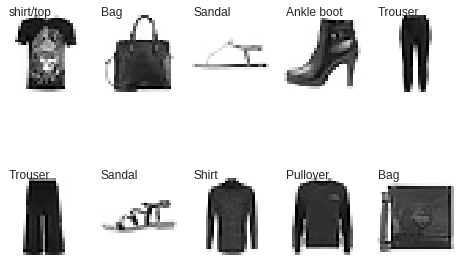

In [4]:
view_image(x_train, y_train)

View 10 random images from the validation set

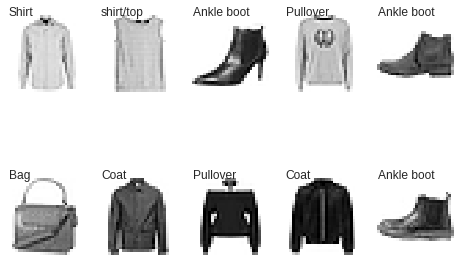

In [5]:
view_image(x_val, y_val)

View 10 random images from the test set

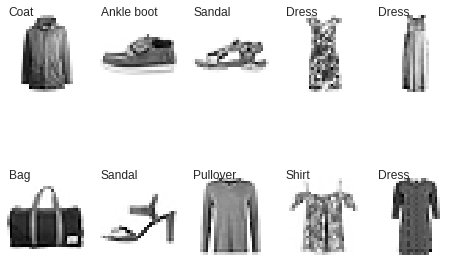

In [6]:
view_image(x_test, y_test)

## 3. Build a softmax regression model (a 1 layer neural network)and train it on the dataset.


Build Computational Graph

In [0]:
# input 
X = tf.placeholder(tf.float32, [None,784])
# labels (onehot encoded)
y = tf.placeholder(tf.float32, [None, 10])
# weights
W = tf.Variable(tf.zeros([784, 10]))
# biases
b = tf.Variable(tf.zeros([10]))

# weigthed sum
z = tf.matmul(X, W) + b

# softmax activation
h = tf.nn.softmax(z)

# softmax cross entropy loss
cross_entropy = -tf.reduce_mean(y * tf.log(h))

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(h, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training, learning rate = 0.005
# learning rate
lr = 0.05
train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)


Start the session

In [0]:
# initialize all variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


Train for 100 epochs

In [9]:
history = training(x_train, y_train, x_val, y_val, sess, epochs=100)

EPOCH 1.0
 train accuracy:0.6953818train loss: 0.09748107
 ********* validation accuracy:0.7118 validation loss: 0.0950911
EPOCH 2.0
 train accuracy:0.7402train loss: 0.081834316
 ********* validation accuracy:0.7562 validation loss: 0.07904902
EPOCH 3.0
 train accuracy:0.7607273train loss: 0.074757285
 ********* validation accuracy:0.7794 validation loss: 0.071665175
EPOCH 4.0
 train accuracy:0.7740545train loss: 0.07041457
 ********* validation accuracy:0.7934 validation loss: 0.067059115
EPOCH 5.0
 train accuracy:0.78334546train loss: 0.067379616
 ********* validation accuracy:0.8022 validation loss: 0.063785546
EPOCH 6.0
 train accuracy:0.7894545train loss: 0.0650997
 ********* validation accuracy:0.81 validation loss: 0.06128302
EPOCH 7.0
 train accuracy:0.7950364train loss: 0.06330534
 ********* validation accuracy:0.8182 validation loss: 0.059277657
EPOCH 8.0
 train accuracy:0.79890907train loss: 0.06184602
 ********* validation accuracy:0.8222 validation loss: 0.05761658
EPOCH 

plot the train and validation acurracy and loss against the number of epochs

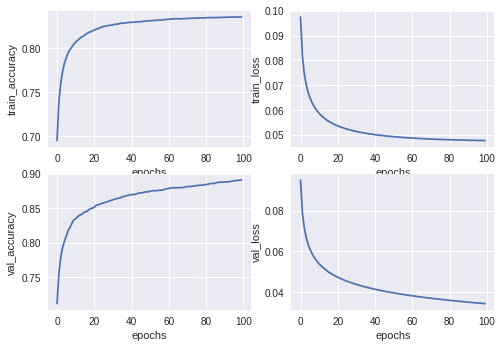

In [10]:
plot_history(history)

Obtain the test accuracy

In [11]:
a_test, c_test  = sess.run([accuracy, cross_entropy], feed_dict={X: x_test, y: y_test})

print('Test accuracy is: ', ("%.2f"%(a_test*100))+'%')

Test accuracy is:  82.24%


In [0]:
sess.close()

You can try increasing the number of epochs for better accuracy

## 4. Add a hidden layer of 200 neurons, use sigmoid activation for hidden units, train and obtain train, validation and test accuracies and loss

Computational graph

In [0]:
#Create computational graph

# input 
X = tf.placeholder(tf.float32, [None,784])
# labels (onehot encoded)
y = tf.placeholder(tf.float32, [None, 10])

''' First hidden layer with 200 neurons'''
# weights 1
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.1))
# biases 1
b1 = tf.Variable(tf.zeros([200]))

# weigthed sum
z1 = tf.matmul(X, W1) + b1

#  activation
h1 = tf.nn.sigmoid(z1)


''' Second/output Layer'''
# weights 2
W2 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
# biases 2
b2 = tf.Variable(tf.zeros([10]))

# weigthed sum
z2 = tf.matmul(h1, W2) + b2

# softmax activation
h2 = tf.nn.softmax(z2)

# softmax cross entropy loss
cross_entropy = -tf.reduce_mean(y * tf.log(h2))

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(h2, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training, learning rate = 0.005
# learning rate
lr = 0.005
train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)

Start session

In [0]:
#Start session

# initialize all variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


In [15]:
history = training(x_train, y_train, x_val, y_val, sess, epochs=100)

EPOCH 1.0
 train accuracy:0.14101818train loss: 0.22722015
 ********* validation accuracy:0.139 validation loss: 0.22754823
EPOCH 2.0
 train accuracy:0.29067272train loss: 0.21755482
 ********* validation accuracy:0.2964 validation loss: 0.21705866
EPOCH 3.0
 train accuracy:0.36741817train loss: 0.20957184
 ********* validation accuracy:0.379 validation loss: 0.20878148
EPOCH 4.0
 train accuracy:0.43227273train loss: 0.20209558
 ********* validation accuracy:0.4466 validation loss: 0.20112883
EPOCH 5.0
 train accuracy:0.50823635train loss: 0.195091
 ********* validation accuracy:0.5216 validation loss: 0.19398226
EPOCH 6.0
 train accuracy:0.5497818train loss: 0.18853155
 ********* validation accuracy:0.5646 validation loss: 0.18729918
EPOCH 7.0
 train accuracy:0.57345456train loss: 0.18238968
 ********* validation accuracy:0.5846 validation loss: 0.18104811
EPOCH 8.0
 train accuracy:0.59147274train loss: 0.17664066
 ********* validation accuracy:0.6028 validation loss: 0.17520258
EPOCH

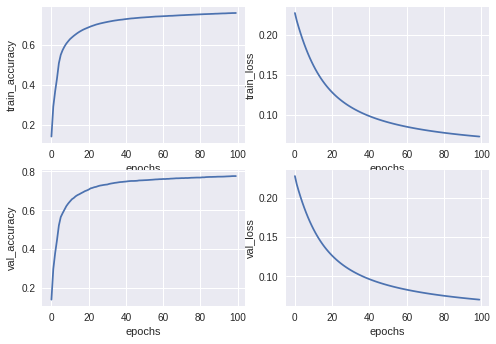

In [16]:
plot_history(history)

In [17]:
a_test, c_test  = sess.run([accuracy, cross_entropy], feed_dict={X: x_test, y: y_test})

print('Test accuracy is: ', ("%.2f"%(a_test*100))+'%')

Test accuracy is:  75.02%


In [0]:
sess.close()

You can try increasing the number of epochs for better accuracy

# You are to build the computational graph by completing the required code statement with None assigned

## 5. Build a five layer neural network with sigmoid activation

In [0]:
#Create computational graph

# input 
X = tf.placeholder(tf.float32, [None,784])
# labels (onehot encoded)
y = tf.placeholder(tf.float32, [None, 10])

''' First hidden layer with 200 neurons'''
# weights 1
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.1))
# biases 1
b1 = tf.Variable(tf.zeros([200]))

# weigthed sum
z1 = tf.matmul(X, W1) + b1

#  activation
h1 = tf.nn.sigmoid(z1)

''' Second hidden layer with 100 neurons'''
################## START CODE #########################
# weights 1
W2 = None
# biases 1
b2 = None

# weigthed sum
z2 = tf.matmul(h1, W2) + b2

#  activation
h2 = tf.nn.sigmoid(z2)

####################### END #############################

''' third Layer with 60 neurons'''
##################### START CODE #########################
# weights 2
W3 = None
# biases 2
b3 = None

# weigthed sum
z3 = None
#  activation
h3 = None

#################### END ##################################

''' fourth Layer with 30 neurons'''
##################### START CODE #########################
# weights 2
W4 = None
# biases 2
b4 = tf.Variable(tf.zeros([30]))

# weigthed sum
z4 = None


#  activation
h4 = None

#################### END ##################################

''' fifth/output Layer with 10 neurons'''
##################### START CODE #########################
# weights 2
W5 = None
# biases 2
b5 = None
# weigthed sum
z5 = None

# softmax activation (optional)
h5 = tf.nn.softmax(z5)

#################### END ##################################



# cross-entropy loss function (= -sum(y_i * log(hi)) )
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=z5, labels=y)
cross_entropy = tf.reduce_mean(cross_entropy)

################### END ###############################

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(h5, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training
################# START CODE ########################
# learning rate
lr = None
train_step = None

################# END ###############################

Start a session

In [0]:
#Start session

# initialize all variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


Train & visualize train/val loss and accuracy

In [0]:
history = training(x_train, y_train, x_val, y_val, sess, epochs=100)

In [0]:
plot_history(history)

Test accuracy

In [0]:
a_test, c_test  = sess.run([accuracy, cross_entropy], feed_dict={X: x_test, y: y_test})

print('Test accuracy is: ', ("%.2f"%(a_test*100))+'%')

## 6. Replace the sigmoid activations with relu

Computational graph

In [0]:
#Create computational graph

# input 
X = tf.placeholder(tf.float32, [None,784])
# labels (onehot encoded)
y = tf.placeholder(tf.float32, [None, 10])

''' First hidden layer with 200 neurons'''
################## START CODE #########################
# weights 1
W1 = None
# biases 1
b1 = None

# weigthed sum
z1 = None

#  activation
h1 = tf.nn.relu(z1)
####################### END #############################

''' Second hidden layer with 100 neurons'''
################## START CODE #########################
# weights 1
W2 = None
# biases 1
b2 = None

# weigthed sum
z2 = None

# activation
h2 = tf.nn.relu(z2)

####################### END #############################

''' third Layer with 60 neurons'''
##################### START CODE #########################
# weights 2
W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1))
# biases 2
b3 = None

# weigthed sum
z3 = tf.matmul(h2, W3) + b3

# activation
h3 = None

#################### END ##################################

''' fourth Layer with 30 neurons'''
##################### START CODE #########################
# weights 2
W4 = None
# biases 2
b4 = tf.Variable(tf.zeros([30]))

# weigthed sum
z4 = None

# activation 
h4 = None

#################### END ##################################

''' fifth/output Layer with 10 neurons'''
##################### START CODE #########################
# weights 2
W5 = None
# biases 2
b5 = None
# weigthed sum
z5 = None

# softmax activation (optional)
h5 = tf.nn.softmax(z5)

#################### END ##################################



# cross-entropy loss function (= -sum(yi * log(hi)) )
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=z5, labels=y)
cross_entropy = tf.reduce_mean(cross_entropy)

################### END ###############################

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = None
accuracy = None

# training
################# START CODE ########################
# learning rate
lr = None
train_step = None

################# END ###############################

Start a session

In [0]:
#Start session

# initialize all variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


Train & visualize train/val loss and accuracy

In [0]:
history = training(x_train, y_train, x_val, y_val, sess, epochs=100)

In [0]:
plot_history(history)

Test Accuracy

In [0]:
a_test, c_test  = sess.run([accuracy, cross_entropy], feed_dict={X: x_test, y: y_test})

print('Test accuracy is: ', ("%.2f"%(a_test*100))+'%')

## 7. Introduce learning rate decay

Computational graph

In [0]:
#Create computational graph

# input 
X = tf.placeholder(tf.float32, [None,784])
# labels (onehot encoded)
y = tf.placeholder(tf.float32, [None, 10])
# step for variable learning rate
step_val = tf.placeholder(tf.int32)

''' First hidden layer with 200 neurons'''
####################### START CODE #############################
# weights 1
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.1))
# biases 1
b1 = None

# weigthed sum
z1 = None

#  activation
h1 = tf.nn.relu(z1)
####################### END #############################

''' Second hidden layer with 100 neurons'''
################## START CODE #########################
# weights 1
W2 = None
# biases 1
b2 = None

# weigthed sum
z2 = None
# activation
h2 = tf.nn.relu(z2)

####################### END #############################

''' third Layer with 60 neurons'''
##################### START CODE #########################
# weights 2
W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1))
# biases 2
b3 = None

# weigthed sum
z3 = None

# activation
h3 = None

#################### END ##################################

''' fourth Layer with 30 neurons'''
##################### START CODE #########################
# weights 2
W4 = None
# biases 2
b4 = tf.Variable(tf.zeros([30]))

# weigthed sum
z4 = None

# activation 
h4 = None

#################### END ##################################

''' fifth/output Layer with 10 neurons'''
##################### START CODE #########################
# weights 2
W5 = None
# biases 2
b5 = None
# weigthed sum
z5 = None

# softmax activation (optional)
h5 = tf.nn.softmax(z5)

#################### END ##################################




# cross-entropy loss function (= -sum(yi * log(hi)) )
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=z5, labels=y)
cross_entropy = tf.reduce_mean(cross_entropy)

################### END ###############################

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(h5, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training
################# START CODE ########################
# the learning rate is: # 0.0001 + 0.003 * (1/e)^(step/2000)), i.e. exponential decay from 0.003->0.0001
lr = 0.0001 +  tf.train.exponential_decay(0.003, step_val, 2000, 1/math.e)
train_step = None

################# END ###############################

Start Session

In [0]:
#Start session

# initialize all variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


Train & visualize train/val loss and accuracy

In [0]:
history = training(x_train, y_train, x_val, y_val, sess, epochs=100, step=True)

In [0]:
plot_history(history)

Test Accuracy

In [0]:
a_test, c_test  = sess.run([accuracy, cross_entropy], feed_dict={X: x_test, y: y_test})

print('Test accuracy is: ', ("%.2f"%(a_test*100))+'%')

In [0]:
sess.close()

## 8. Use dropout

Computational graph

In [0]:
#Create computational graph

# input 
X = tf.placeholder(tf.float32, [None,784])
# labels (onehot encoded)
y = tf.placeholder(tf.float32, [None, 10])
# step for variable learning rate
step_val = tf.placeholder(tf.int32)

# variable learning rate
lr = tf.placeholder(tf.float32)
# Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep_val = tf.placeholder(tf.float32)


''' First hidden layer with 200 neurons'''
################## START CODE #########################
# weights 1
W1 = None
# biases 1
b1 = None

# weigthed sum
z1 = tf.matmul(X, W1) + b1

#  activation
h1 = None

# dropout
h1d = tf.nn.dropout(h1, pkeep_val)
################## END #########################

''' Second hidden layer with 100 neurons'''
################## START CODE #########################
# weights 1
W2 = None
# biases 1
b2 = None

# weigthed sum
z2 = tf.matmul(h1d, W2) + b2

# activation
h2 = tf.nn.relu(z2)

# dropout
h2d = None


####################### END #############################

''' third Layer with 60 neurons'''
##################### START CODE #########################
# weights 2
W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1))
# biases 2
b3 = None

# weigthed sum
z3 = tf.matmul(h2d, W3) + b3

# activation
h3 = None

# dropout
h3d = None

#################### END ##################################

''' fourth Layer with 30 neurons'''
##################### START CODE #########################
# weights 2
W4 = None
# biases 2
b4 = tf.Variable(tf.zeros([30]))

# weigthed sum
z4 = None

# activation 
h4 = None

# dropout
h4d = None


#################### END ##################################

''' fifth/output Layer with 10 neurons'''
##################### START CODE #########################
# weights 2
W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1))#None
# biases 2
b5 = None
# weigthed sum
z5 = None

# softmax activation
h5 = tf.nn.softmax(z5)

#################### END ##################################





# cross-entropy loss function (= -sum(yi * log(hi)) )
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=z5, labels=y)
cross_entropy = tf.reduce_mean(cross_entropy)

################### END ###############################

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(h5, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training
################# START CODE ########################
# the learning rate is: # 0.0001 + 0.003 * (1/e)^(step/2000)), i.e. exponential decay from 0.003->0.0001
lr = 0.0001 +  tf.train.exponential_decay(0.003, step_val, 2000, 1/math.e)
train_step = None


################# END ###############################

Start session

In [0]:
#Start session

# initialize all variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


Train & visualize train/val loss and accuracy

In [0]:
history = training(x_train, y_train, x_val, y_val, sess, epochs=100, step=True, pkeep=0.75)

In [0]:
plot_history(history)

Test Accuracy

In [0]:
a_test, c_test  = sess.run([accuracy, cross_entropy], feed_dict={X: x_test, y: y_test, pkeep_val: 1})

print('Test accuracy is: ', ("%.2f"%(a_test*100))+'%')

## 9. Convolutional Neural Networks

In [0]:
''' Let Your Imagination Run Wild'''